In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
#用于直接在Jupyter中画图

plt.rcParams['figure.figsize']=(5.0,4.0)    #设置图像最大范围
plt.rcParams['image.interpolation']='nearest'   #差值方式 设置 interpolation style
plt.rcParams['image.cmap']='gray'   #灰度空间

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


In [2]:
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [10]:
def zero_pad(X,pad):
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values=0)
    #               #()中表示每个轴边缘需要填充的数值数目     constant表示用连续相同值填充

    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


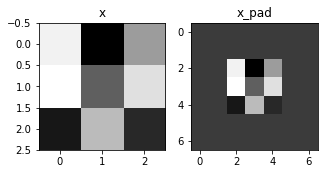

In [12]:
np.random.seed(1)
x=np.random.randn(4,3,3,2)
x_pad=zero_pad(x,2)

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])


fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])


In [13]:
def conv_single_step(a_slice_prev,W,b):

    s=np.multiply(a_slice_prev,W)+b

    Z=np.sum(s)

    return Z

In [14]:
np.random.seed(1)
a_slice_prev=np.random.randn(4,4,3)
W=np.random.randn(4,4,3)
b=np.random.randn(1,1,1)

Z=conv_single_step(a_slice_prev,W,b)
print('Z=',Z)

Z= -23.16021220252078


In [21]:
def conv_forward(A_prev,W,b,hparameters):

    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape     #图片 m个图片  n_H_prev,n_W_prev,n_C_prev分别为X,Y,Z

    (f,f,n_c_prev,n_C)=W.shape      #f,f,n_c_prev为x,y,z

    stride=hparameters['stride']
    pad=hparameters['pad']

    n_H=1+int((n_H_prev-f+2*pad)/stride)
    n_W=1+int((n_W_prev-f+2*pad)/stride)

    Z=np.zeros((m,n_H,n_W,n_C))
    A_prev_pad=zero_pad(A_prev,pad) #把原图像扩充

    
    for i in range(m):
        a_prev_pad=A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start=h*stride
                    vert_end=vert_start+f
                    horiz_start=w*stride
                    horiz_end=horiz_start+f

                    a_slice_prev=a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]    #原图像切片

                    Z[i, h, w, c] = np.sum(np.multiply(a_slice_prev, W[:, :, :, c]) + b[:, :, :, c])    #保存结果

    assert(Z.shape==(m,n_H,n_W,n_C))

    cache=(A_prev,W,b,hparameters)

    return Z,cache

In [22]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [23]:
def pool_forward(A_prev,hparameters,mode='max'):
    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape

    f=hparameters['f']
    stride=hparameters['stride']

    n_H=int(1+(n_H_prev-f)/stride)
    n_W=int(1+(n_W_prev-f)/stride)
    n_C=n_C_prev

    A=np.zeros((m,n_H,n_W,n_C))

    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start=h*stride
                    vert_end=vert_start+f
                    horiz_start=w*stride
                    horiz_end=horiz_start+f

                    a_prev_slice=A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    if mode=='max':
                        A[i,h,w,c]=np.max(a_prev_slice)
                    elif mode=='average':
                        A[i,h,w,c]=np.mean(a_prev_slice)

    cache=(A_prev,hparameters)

    assert(A.shape==(m,n_H,n_W,n_C))
    
    return A,cache
 

In [24]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


In [25]:
def conv_backward(dZ,cache):
    (A_prev,W,b,hparameters)=cache

    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape

    (f,f,n_C_prev,n_c)=W.shape

    stride=hparameters['stride']
    pad=hparameters['pad']

    (m,n_H,n_W,n_C)=dZ.shape

    dA_prev=np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW=np.zeros((f,f,n_C_prev,n_C))
    db=np.zeros((1,1,1,n_C))

    A_prev_pad=zero_pad(A_prev,pad)
    dA_prev_pad=zero_pad(dA_prev,pad)

    for i in range(m):

        a_prev_pad=A_prev_pad[i]
        da_prev_pad=dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start=h*stride
                    vert_end=vert_start+f
                    horiz_start=w*stride
                    horiz_end=horiz_start+f

                    a_slice=a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    da_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]+=W[:,:,:,c]*dZ[i,h,w,c]
                    dW[:,:,:,c]+=a_slice*dZ[i,h,w,c]
                    db[:,:,:,c]+=dZ[i,h,w,c]
        
        dA_prev[i,:,:,:]=dA_prev_pad[i,pad:-pad,pad:-pad,:]

    assert(dA_prev.shape==(m,n_H_prev,n_W_prev,n_C_prev))

    return dA_prev,dW,db



In [26]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


In [29]:
def create_mask_from_window(x):
    mask=(x==np.max(x))

    return mask

In [30]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [31]:
def distribute_value(dz,shape):
    (n_H,n_W)=shape

    average=dz/(n_H*n_W)

    a=np.ones(shape)*average

    return a

In [32]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [33]:
def pool_backward(dA,cache,mode='max'):
    (A_prev,hparameters)=cache
    
    stride=hparameters['stride']
    f=hparameters['f']

    m,n_H_prev,n_W_prev,n_C_prev=A_prev.shape
    m,n_H,n_W,n_C=dA.shape

    dA_prev=np.zeros_like(A_prev)

    for i in range(m):

        a_prev=A_prev[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start=h*stride
                    vert_end=vert_start+f
                    horiz_start=w*stride
                    horiz_end=horiz_start+f

                    if mode=='max':
                        a_prev_slice=a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        mask=create_mask_from_window(a_prev_slice)
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]+=mask*dA[i,vert_start,horiz_start,c]

                    elif mode=='average':
                        da=dA[i,vert_start,horiz_start,c]
                        shape=(f,f)
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]+=distribute_value(da,shape)

    assert(dA_prev.shape==A_prev.shape)

    return dA_prev
    

In [34]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
